#### passing shuffled images to a simple CNN network for classification using <br> cross entropy as loss, a shuffled image's tile are seperately passed to different channels

In [2]:
import numpy as np 
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [3]:
images = np.load('tranformed_cavallo.npy')
print(images.shape)

(2623, 120, 120, 3)


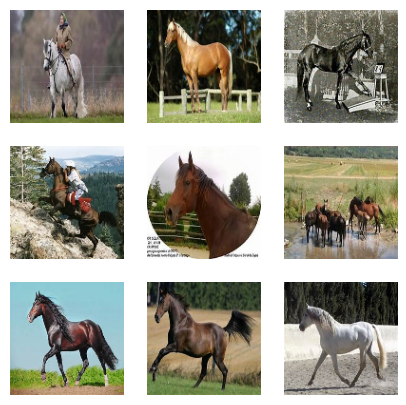

In [4]:
# example of dataset
fig, axes = plt.subplots(3, 3, figsize=(5, 5))
for i, ax in enumerate(axes.flat):
    ax.imshow(cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB))
    ax.axis('off')

plt.show()

In [5]:
def divide_image(image):
    parts = []
    height, width, _ = image.shape
    part_height = height // 3
    part_width = width // 3
    
    for i in range(3):
        for j in range(3):
            part = image[i*part_height:(i+1)*part_height, j*part_width:(j+1)*part_width]
            parts.append(part)
    
    return parts

In [6]:
def generate_combinations(parts, num_combinations):
    combinations = []
    original_positions = []
    indices = list(range(len(parts)))
    
    for _ in range(num_combinations):
        random.shuffle(indices)
        combination = [parts[i] for i in indices]
        combinations.append(combination)
        original_positions.append(indices.copy())
    
    return combinations, original_positions

In [7]:
def generate_flow_wrap(original_positions):

    flow_wrap = []
    for curr, true in enumerate(original_positions):
        for i in range(3):
            for j in range(3):
                if 3*i+j == true:
                    flow_wrap.append((i-curr//3)/2)
                    flow_wrap.append((j-curr%3)/2)

    return flow_wrap

In [8]:
def stitch_shuffled_image(parts):
    num_parts = len(parts)
    part_size = parts[0].shape[0]  # Assuming all parts are square
    
    stitched_image_size = int(np.sqrt(num_parts) * part_size)
    stitched_image = np.zeros((stitched_image_size, stitched_image_size, parts[0].shape[2]), dtype=np.uint8)
    
    for i in range(stitched_image.shape[0] // part_size):
        for j in range(stitched_image.shape[1] // part_size):
            part_index = i * int(stitched_image.shape[0] / part_size) + j
            stitched_image[i*part_size:(i+1)*part_size, j*part_size:(j+1)*part_size] = parts[part_index]
    
    return stitched_image

In [9]:
input_data = []
target_data = []
non_converted_target_data = []

for image in images:
    parts = divide_image(image)
    combinations, original_positions = generate_combinations(parts, 10)

    for idx, combination in enumerate(combinations):

        # shape of combination is (9, 40, 40, 3)
        combination = np.array(combination).transpose(0, 3, 1, 2)
        combination = np.concatenate(combination, axis=0).transpose(1, 2, 0)
        input_data.append(combination)

        # dummy_target = np.zeros((9, 9), dtype=np.uint8)
        # for i in range(9):
        #     dummy_target[i, original_positions[idx][i]] = 1


        flow_wrap = generate_flow_wrap(original_positions[idx])
        flow_wrap = np.array(flow_wrap)
 
        target_data.append(flow_wrap)
        non_converted_target_data.append(original_positions[idx])

In [10]:
input_data = np.array(input_data)
target_data = np.array(target_data)

print("Input data shape:", input_data.shape)
print("Target data shape:", target_data.shape)

Input data shape: (26230, 40, 40, 27)
Target data shape: (26230, 18)


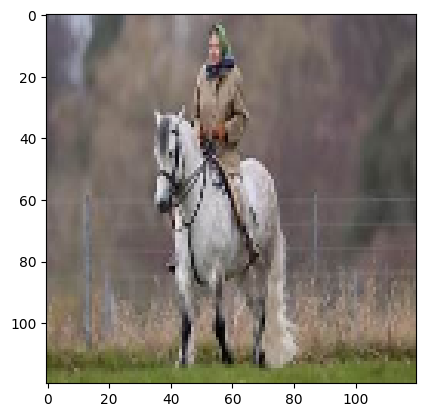

In [11]:
# checking if the target sequence is correct
def reconstructed_image(img, non_converted_target_data, test=False):
    
    sequenced = [0] * 9
    for i in range(0,27,3):

        # stack the 3 channels to get the original image
        blue_channel = img[:,:,i]
        green_channel = img[:,:,i+1]
        red_channel = img[:,:,i+2]

        # stack the 3 channels to get the original image
        tile = np.stack((blue_channel, green_channel, red_channel), axis=2)

        if test:
            sequenced[i // 3] = tile
        else:
            sequenced[non_converted_target_data[i // 3]] = tile

    stiched_img = stitch_shuffled_image(sequenced)
    return stiched_img


reconstructed_img = reconstructed_image(input_data[idx], non_converted_target_data[idx])
plt.imshow(cv2.cvtColor(reconstructed_img, cv2.COLOR_BGR2RGB))

In [12]:
class JigsawDataset(Dataset):
    def __init__(self, input_data, target_data, transform=None):
        self.input_data = input_data
        self.target_data = target_data
        self.transform = transform
        
    def __len__(self):
        return len(self.input_data)
    
    def __getitem__(self, idx):
        image = self.input_data[idx]
        target = self.target_data[idx]
        
        if self.transform:
            image = self.transform(image)
        
        return image, target

In [13]:
class JigsawModel(nn.Module):
    def __init__(self):
        super(JigsawModel, self).__init__()
        self.conv1 = nn.Conv2d(27, 512, 3, padding=1)
        self.conv2 = nn.Conv2d(512, 256, 3, padding=1)
        self.conv3 = nn.Conv2d(256, 128, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(3200 , 2000)
        self.fc2 = nn.Linear(2000, 1024)
        self.fc3 = nn.Linear(1024, 512) 
        self.fc4 = nn.Linear(512, 18)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 3200)

        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)

        return x

In [14]:
model = JigsawModel()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 30
batch_size = 64

In [15]:
X_train, X_test, y_train, y_test = train_test_split(input_data, target_data, test_size=0.2, random_state=42)

train_dataset = JigsawDataset(X_train, y_train)
test_dataset = JigsawDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=True)

In [25]:
for epoch in range(num_epochs):
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        
        # cnn input shape is (batch_size, channels, height, width)
        inputs = inputs.permute(0, 3, 1, 2).float()
        optimizer.zero_grad()
        
        outputs = model(inputs)   
        loss = criterion(outputs, labels.float())
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    print('Epoch: %d, Batch: %5d, Loss: %.3f' % (epoch + 1, i + 1, running_loss / 100))
    running_loss = 0.0

print('Finished Training')

Epoch: 1, Batch:   327, Loss: 55.939
Epoch: 2, Batch:   327, Loss: 0.544
Epoch: 3, Batch:   327, Loss: 0.534
Epoch: 4, Batch:   327, Loss: 0.522
Epoch: 5, Batch:   327, Loss: 0.511
Epoch: 6, Batch:   327, Loss: 0.504
Epoch: 7, Batch:   327, Loss: 0.498
Epoch: 8, Batch:   327, Loss: 0.493
Epoch: 9, Batch:   327, Loss: 0.481
Epoch: 10, Batch:   327, Loss: 0.473
Epoch: 11, Batch:   327, Loss: 0.464
Epoch: 12, Batch:   327, Loss: 0.454
Epoch: 13, Batch:   327, Loss: 0.446
Epoch: 14, Batch:   327, Loss: 0.439
Epoch: 15, Batch:   327, Loss: 0.430
Epoch: 16, Batch:   327, Loss: 0.425
Epoch: 17, Batch:   327, Loss: 0.418
Epoch: 18, Batch:   327, Loss: 0.412
Epoch: 19, Batch:   327, Loss: 0.404
Epoch: 20, Batch:   327, Loss: 0.397
Epoch: 21, Batch:   327, Loss: 0.392
Epoch: 22, Batch:   327, Loss: 0.385
Epoch: 23, Batch:   327, Loss: 0.378
Epoch: 24, Batch:   327, Loss: 0.374
Epoch: 25, Batch:   327, Loss: 0.370
Epoch: 26, Batch:   327, Loss: 0.362
Epoch: 27, Batch:   327, Loss: 0.358
Epoch: 28

In [32]:
# save the model
torch.save(model.state_dict(), 'flow_wrap_model.pth')

In [36]:
correct = 0
total = 0
per_tile_accuracy = 0

model.eval()
with torch.no_grad():
    for data in test_loader:
        inputs, labels = data
        inputs = inputs.permute(0, 3, 1, 2).float()
        outputs = model(inputs)

        #output shape is (batch_size, 18)
        # reshape the output which is (64,18) to 9x9 matrix

        outputs = outputs.reshape(-1, 2, 9)
        predicted = torch.argmax(outputs, dim=1)

        # now doing the same for the target
        labels = labels.reshape(-1, 2, 9)
        target = torch.argmax(labels, dim=1)

        print(outputs)
        print(labels)
        break

tensor([[[ 0.0488,  0.4831,  0.3235,  ...,  0.1390,  0.6675,  0.2168],
         [ 0.0316, -0.0410, -0.5302,  ...,  0.0698, -0.2748, -0.5467]],

        [[-0.0031,  0.2550,  0.4110,  ..., -0.3545,  0.4849,  0.2376],
         [-0.0058,  0.1440, -0.3861,  ..., -0.1071, -0.4296, -0.4984]],

        [[ 0.8362,  0.4248,  0.9176,  ...,  0.4888,  0.5708, -0.3741],
         [ 0.0560, -0.0850, -0.3137,  ..., -0.0090, -0.8995, -0.5771]],

        ...,

        [[ 0.4540,  0.4445,  0.0826,  ..., -0.0417,  0.4453,  0.3068],
         [ 0.2147, -0.4918, -0.4337,  ..., -0.2013, -1.0580, -0.8616]],

        [[ 0.3048,  0.7006,  0.7882,  ..., -0.0610,  0.5757,  0.1349],
         [-0.0530, -0.0480, -0.5887,  ...,  0.0464, -0.2821, -0.4983]],

        [[ 0.7004,  0.1083,  0.0740,  ...,  0.0048,  0.4444,  0.0687],
         [ 0.0134, -0.3392, -0.5482,  ..., -0.0058, -0.4874, -0.3791]]])
tensor([[[ 0.0000,  1.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.5000, -0.5000,  ...,  0.0000,